In [31]:
import os, asyncio, json, re, sqlite3, pandas as pd
from typing import Annotated, Any
from typing_extensions import TypedDict
from dotenv import load_dotenv
load_dotenv(override=True)

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from langchain_openai import ChatOpenAI

# Use the model you have access to
LLM = ChatOpenAI(model="gpt-4o-mini", temperature=0)
DATA_DIR = "./data"   # your folder with CSVs
SQLITE_DB_PATH = "demo_text_to_sql.db"
print("Using data dir:", DATA_DIR)

Using data dir: ./data


In [32]:
import numpy as np

def to_python(obj):
    """
    Recursively convert numpy/pandas dtypes to pure Python types
    so LangGraph JSON serialization will not fail.
    """
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    if isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    if isinstance(obj, (np.bool_,)):
        return bool(obj)
    if isinstance(obj, (np.ndarray, list, tuple)):
        return [to_python(x) for x in obj]
    if isinstance(obj, dict):
        return {k: to_python(v) for k, v in obj.items()}
    return obj


In [33]:
# %%
# build RICH schema catalog from CSVs (enterprise-style)
def infer_semantic_type(series: pd.Series) -> str:
    """Rough semantic type inference for a column."""
    try:
        if pd.api.types.is_datetime64_any_dtype(series):
            return "datetime"
    except Exception:
        pass

    # Try parse datetime if many values look like dates
    try:
        sample = series.dropna().astype(str).head(50)
        parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
        if parsed.notna().mean() > 0.7:
            return "datetime"
    except Exception:
        pass

    if pd.api.types.is_numeric_dtype(series):
        return "numeric"

    nunique = series.nunique(dropna=True)
    # small cardinality → categorical
    if nunique > 0 and nunique <= 50:
        return "categorical"

    return "text"


def profile_column(series: pd.Series, max_distinct: int = 20) -> dict:
    """Profile a single column: type, distinct values, nulls, etc."""
    series_non_null = series.dropna()
    semantic_type = infer_semantic_type(series)

    distinct_vals = []
    try:
        distinct_vals = list(series_non_null.unique()[:max_distinct])
    except Exception:
        pass

    sample_vals = []
    try:
        sample_vals = list(series_non_null.astype(str).head(5))
    except Exception:
        pass

    profile = {
        "semantic_type": semantic_type,
        "distinct_values": distinct_vals,
        "sample_values": sample_vals,
        "n_unique": int(series_non_null.nunique()),
        "n_null": int(series.isna().sum()),
    }

    # For numerics, add min/max
    if semantic_type == "numeric":
        try:
            profile["min"] = float(series_non_null.min())
            profile["max"] = float(series_non_null.max())
        except Exception:
            profile["min"] = None
            profile["max"] = None

    return profile


def build_schema_from_csv_folder(data_dir: str):
    """
    Build a rich schema catalog with:
      - table-level info (rows, columns)
      - per-column profile (type, distinct values, samples)
      - PK candidates
      - FK candidates (join hints)
      - natural-language table summary
    """
    catalog: dict[str, dict] = {}
    dataframes: dict[str, pd.DataFrame] = {}

    files = sorted(os.listdir(data_dir))
    for fname in files:
        low = fname.lower()
        if not low.endswith(".csv"):
            continue

        table = os.path.splitext(fname)[0]
        path = os.path.join(data_dir, fname)

        try:
            df = pd.read_csv(path)
        except Exception:
            # try basic fallback
            try:
                df = pd.read_csv(path, nrows=5000)
            except Exception:
                print(f"[WARN] Could not read {path}, skipping")
                continue

        # keep original column names for catalog; SQLite version is separate
        cols = list(df.columns)
        row_count = len(df)

        # column-level profiles
        columns_meta = {}
        for col in cols:
            try:
                series = df[col]
                columns_meta[col] = profile_column(series)
            except Exception:
                columns_meta[col] = {
                    "semantic_type": "unknown",
                    "distinct_values": [],
                    "sample_values": [],
                    "n_unique": 0,
                    "n_null": 0,
                }

        catalog[table] = {
            "columns": cols,
            "source": path,
            "row_count": row_count,
            "columns_meta": columns_meta,
            "pk_candidates": [],   # filled below
            "fk_candidates": [],   # filled below
            "summary": "",         # filled below
        }
        dataframes[table] = df

    # --- PK inference (very simple heuristics) ---
    for t, df in dataframes.items():
        pk_cand = []
        for col in df.columns:
            series = df[col]
            try:
                if series.notna().all() and series.is_unique:
                    # strong candidate if *_id or "id"
                    if col.lower().endswith("_id") or col.lower() == "id":
                        pk_cand.append(col)
            except Exception:
                continue
        catalog[t]["pk_candidates"] = pk_cand

    # --- FK inference (based on name + PK) ---
    for t, df in dataframes.items():
        fk_list = []
        for col in df.columns:
            col_lower = col.lower()
            if not col_lower.endswith("_id"):
                continue

            for other_t, other_meta in catalog.items():
                if other_t == t:
                    continue
                if col in other_meta["columns"] and col in other_meta.get("pk_candidates", []):
                    fk_list.append(
                        {
                            "column": col,
                            "ref_table": other_t,
                            "ref_column": col,
                        }
                    )
        catalog[t]["fk_candidates"] = fk_list

    # --- Table summaries (LLM-agnostic, just deterministic text) ---
    for t, meta in catalog.items():
        cols = meta["columns"]
        cols_meta = meta["columns_meta"]

        col_summaries = []
        for col in cols[:20]:  # cap to keep prompt manageable
            cmeta = cols_meta.get(col, {})
            ctype = cmeta.get("semantic_type", "unknown")
            samples = cmeta.get("sample_values") or []
            distinct = cmeta.get("distinct_values") or []

            detail = f"{col} ({ctype}"
            if distinct and len(distinct) <= 10:
                detail += f", values={distinct}"
            elif samples:
                detail += f", e.g. {samples[:3]}"
            detail += ")"
            col_summaries.append(detail)

        pk_txt = ", ".join(meta.get("pk_candidates", [])) or "None"
        fk_rels = meta.get("fk_candidates", []) or []
        fk_txt = (
            "; ".join(
                f"{fk['column']} -> {fk['ref_table']}.{fk['ref_column']}"
                for fk in fk_rels
            )
            or "None"
        )

        meta["summary"] = (
            f"Table {t} with ~{meta['row_count']} rows. "
            f"PK candidates: {pk_txt}. "
            f"FK candidates: {fk_txt}. "
            f"Important columns: " + "; ".join(col_summaries)
        )

    return catalog


In [34]:
SCHEMA_CATALOG = build_schema_from_csv_folder(DATA_DIR)
print("Tables discovered:", list(SCHEMA_CATALOG.keys()))
# quick view of a table
for t,meta in list(SCHEMA_CATALOG.items())[:5]:
    print(t, "->", meta["columns"][:10])

/var/folders/rb/_3rsrh8j3012dkqq_c8_4hqw0000gp/T/ipykernel_56262/1079416587.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
/var/folders/rb/_3rsrh8j3012dkqq_c8_4hqw0000gp/T/ipykernel_56262/1079416587.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
/var/folders/rb/_3rsrh8j3012dkqq_c8_4hqw0000gp/T/ipykernel_56262/1079416587.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default

Tables discovered: ['blinkit_customer_feedback', 'blinkit_customers', 'blinkit_delivery_performance', 'blinkit_inventory', 'blinkit_inventoryNew', 'blinkit_marketing_performance', 'blinkit_order_items', 'blinkit_orders', 'blinkit_products']
blinkit_customer_feedback -> ['feedback_id', 'order_id', 'customer_id', 'rating', 'feedback_text', 'feedback_category', 'sentiment', 'feedback_date']
blinkit_customers -> ['customer_id', 'customer_name', 'email', 'phone', 'address', 'area', 'pincode', 'registration_date', 'customer_segment', 'total_orders']
blinkit_delivery_performance -> ['order_id', 'delivery_partner_id', 'promised_time', 'actual_time', 'delivery_time_minutes', 'distance_km', 'delivery_status', 'reasons_if_delayed']
blinkit_inventory -> ['product_id', 'date', 'stock_received', 'damaged_stock']
blinkit_inventoryNew -> ['product_id', 'date', 'stock_received', 'damaged_stock']


/var/folders/rb/_3rsrh8j3012dkqq_c8_4hqw0000gp/T/ipykernel_56262/1079416587.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
/var/folders/rb/_3rsrh8j3012dkqq_c8_4hqw0000gp/T/ipykernel_56262/1079416587.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
/var/folders/rb/_3rsrh8j3012dkqq_c8_4hqw0000gp/T/ipykernel_56262/1079416587.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default

In [35]:
def init_sqlite_from_csvs(catalog, db_path=SQLITE_DB_PATH):
    conn = sqlite3.connect(db_path)
    for table, meta in catalog.items():
        path = meta["source"]
        try:
            df = pd.read_csv(path)
        except Exception:
            continue
        # sanitize column names
        df.columns = [re.sub(r"\W+", "_", c).lower() for c in df.columns]
        # write to sqlite (replace to refresh)
        df.to_sql(table, conn, if_exists="replace", index=False)
    conn.commit()
    conn.close()
    print("SQLite DB initialized at", db_path)

init_sqlite_from_csvs(SCHEMA_CATALOG)

SQLite DB initialized at demo_text_to_sql.db


In [36]:
def simple_schema_retrieval(query: str, catalog: dict, n: int = 8):
    """
    Retrieval over tables using:
      - table name match
      - column name match
      - column semantic summaries
      - distinct values for categorical columns
    """
    tokens = set(re.findall(r"\w+", query.lower()))
    scored: list[tuple[int, str]] = []

    for t, meta in catalog.items():
        score = 0
        t_lower = t.lower()

        # table name match
        if any(tok in t_lower for tok in tokens):
            score += 5

        # column name + semantic info
        for col in meta["columns"]:
            col_lower = col.lower()
            if any(tok in col_lower for tok in tokens):
                score += 3

            cmeta = meta.get("columns_meta", {}).get(col, {})
            # check distinct/sample values for categorical/text columns
            values = (cmeta.get("distinct_values") or []) + (cmeta.get("sample_values") or [])
            for v in values:
                v_str = str(v).lower()
                if any(tok in v_str for tok in tokens):
                    score += 1

        # join-related hints (if query mentions "customer", "order", "delivery" etc)
        join_tokens = {"join", "customer", "delivery", "order", "product"}
        if tokens & join_tokens:
            if meta.get("fk_candidates"):
                score += 1
            if meta.get("pk_candidates"):
                score += 1

        scored.append((score, t))

    scored.sort(reverse=True)
    selected = [t for s, t in scored if s > 0][:n]
    if not selected:
        selected = list(catalog.keys())[:min(n, len(catalog))]

    # Return a JSON-serializable subset preserving rich metadata
    found = {}
    for t in selected:
        meta = catalog[t]
        found[t] = {
            "columns": meta["columns"],
            "source": meta["source"],
            "row_count": meta.get("row_count"),
            "columns_meta": meta.get("columns_meta", {}),
            "pk_candidates": meta.get("pk_candidates", []),
            "fk_candidates": meta.get("fk_candidates", []),
            "summary": meta.get("summary", ""),
        }
    return found


def summarize_schema_block_safe(schema_block: dict) -> str:
    """
    Turn a subset of the catalog into a compact, LLM-friendly text summary.
    Uses the precomputed 'summary' field when available.
    """
    parts = []
    for t, meta in schema_block.items():
        if "summary" in meta and meta["summary"]:
            parts.append(meta["summary"])
        else:
            cols = ", ".join(meta.get("columns", [])[:20])
            parts.append(f"Table {t}: columns=[{cols}]")
    return "\n".join(parts)

In [37]:
async def llm_complete(prompt: str) -> str:
    # try a modern async call; fallback to thread if provider doesn't have ainvoke
    try:
        messages = [{"role":"system","content":prompt}]
        res = await LLM.ainvoke(messages)
        if hasattr(res, "content"):
            return res.content
        if isinstance(res, dict) and "content" in res:
            return res["content"]
        return str(res)
    except AttributeError:
        loop = asyncio.get_running_loop()
        def sync_call():
            messages = [{"role":"system","content":prompt}]
            out = LLM.invoke(messages)
            if hasattr(out, "content"):
                return out.content
            if isinstance(out, dict) and "content" in out:
                return out["content"]
            return str(out)
        return await loop.run_in_executor(None, sync_call)

In [38]:
# ============================================
# CELL 6 - LangGraph State + 8 Agents (FINAL)
# ============================================

class State(TypedDict):
    messages: Annotated[list, add_messages]
    user_query: str
    schema_json: str
    schema_text: str
    rewritten_query: str
    join_plan: str
    sql_query: str
    sql_result: Any
    last_sql: str | None
    last_result: Any | None
    conversation_history: list
    error: str | None
    retries: int


# -------------------------------------------------------
# AGENT 1: Schema Retrieval
# -------------------------------------------------------
async def schema_retrieval(state: State):
    # Ensure memory fields exist
    history = state.get("conversation_history") or []
    state["conversation_history"] = to_python(history)

    q = state["user_query"]
    found = simple_schema_retrieval(q, SCHEMA_CATALOG, n=8)

    state["schema_json"] = json.dumps(to_python(found))
    state["schema_text"] = summarize_schema_block_safe(found)

    history.append(
        {"step": "schema", "tables": list(found.keys())}
    )

    return {
        "messages": [{"role": "system", "content": f"Schema retrieval OK: {list(found.keys())}"}],
        "schema_json": state["schema_json"],
        "schema_text": state["schema_text"],
        "conversation_history": history,
        "error": None,
    }


# -------------------------------------------------------
# AGENT 2: Schema Summarizer
# -------------------------------------------------------
async def schema_summarizer(state: State):
    try:
        raw = json.loads(state.get("schema_json", "{}"))
    except Exception:
        raw = {}

    state["schema_text"] = summarize_schema_block_safe(raw)

    return {
        "messages": [{"role": "system", "content": "Schema summary created"}],
        "schema_text": state["schema_text"],
        "error": None,
    }


# -------------------------------------------------------
# AGENT 3: Query Rewriter
# -------------------------------------------------------
async def query_rewriter(state: State):
    history = state.get("conversation_history") or []
    state["conversation_history"] = history
    last_sql = state.get("last_sql") or "None"
    last_result = state.get("last_result") or "None"

    history_text = json.dumps(history, indent=2)

    prompt = f"""
Rewrite the user's query into a precise, schema-grounded intent.

User query:
{state['user_query']}

Conversation history:
{history_text}

Previous SQL:
{last_sql}

Previous Result:
{last_result}

Schema:
{state['schema_text']}

Rewrite as ONE LINE intent that does not depend on vague references.
"""

    out = await llm_complete(prompt)
    rewritten = out.strip().split("\n")[0]

    state["rewritten_query"] = rewritten
    history.append(
        {"step": "rewriter", "rewritten": rewritten}
    )

    return {
        "messages": [{"role": "system", "content": f"Rewritten: {rewritten}"}],
        "rewritten_query": rewritten,
        "conversation_history": history,
        "error": None,
    }


# -------------------------------------------------------
# AGENT 4: Join Planner
# -------------------------------------------------------
async def join_planner(state: State):
    schema_block = json.loads(state["schema_json"])  # allowed subset
    prompt = f"""
You are a join planner for SQLite.

You must ONLY use the tables/columns and join hints inside this JSON:

allowed_schema = {json.dumps(schema_block, indent=2)}

Use fk_candidates to propose 1–3 valid join paths.
If no valid join path exists in allowed_schema, respond with a single-table plan.

Rewritten intent:
{state['rewritten_query']}

Return:
tables: [...]
joins:
  - tableA.col = tableB.col
"""

    out = await llm_complete(prompt)
    state["join_plan"] = out.strip()

    return {
        "messages": [{"role": "system", "content": "Join plan ready"}],
        "join_plan": state["join_plan"],
        "error": None,
    }


# -------------------------------------------------------
# AGENT 5: SQL Generator
# -------------------------------------------------------
async def sql_generator(state: State):
    history = state.get("conversation_history") or []
    state["conversation_history"] = history

    prompt = f"""
Generate a VALID SQLite SQL query for this intent:
{state['rewritten_query']}

Join plan:
{state['join_plan']}

Schema:
{state['schema_text']}

Return ONLY the SQL. No markdown.
"""

    raw = await llm_complete(prompt)

    cleaned = (
        raw.replace("```sql", "")
           .replace("```SQL", "")
           .replace("```", "")
           .strip()
    )

    match = re.search(r"(?i)(select.*?;)", cleaned, re.S)
    sql = match.group(1).strip() if match else cleaned.strip()

    if not sql.endswith(";"):
        sql += ";"

    state["sql_query"] = sql
    history.append(
        {"step": "sql_generated", "sql": sql}
    )

    return {
        "messages": [{"role": "system", "content": f"SQL generated: {sql}"}],
        "sql_query": sql,
        "conversation_history": history,
        "error": None,
    }


# -------------------------------------------------------
# AGENT 6: Static Analyzer
# -------------------------------------------------------
async def static_analyzer(state: State):
    sql = state.get("sql_query", "")
    errors = []

    # Block dangerous operations
    if re.search(r"\b(drop|delete|update|insert|alter)\b", sql, re.I):
        errors.append("Unsafe operation detected")

    # Simple heuristic — but allow SUM without GROUP BY for now
    # (you can improve this later if needed)

    if errors:
        issue = "; ".join(errors)
        state["error"] = issue
        return {
            "messages": [{"role": "system", "content": issue}],
            "error": issue,
        }

    state["error"] = None
    return {
        "messages": [{"role": "system", "content": "Static analysis OK"}],
        "error": None,
    }


# -------------------------------------------------------
# AGENT 7: SQL Executor (SQLite)
# -------------------------------------------------------
async def executor(state: State):
    history = state.get("conversation_history") or []
    history = to_python(history)
    state["conversation_history"] = history

    sql = state.get("sql_query", "")

    if not sql.lower().startswith("select"):
        issue = "Only SELECT queries allowed"
        state["error"] = issue
        return {
            "messages": [{"role": "system", "content": issue}],
            "sql_result": None,
            "error": issue,
        }

    try:
        conn = sqlite3.connect(SQLITE_DB_PATH, timeout=5)
        cur = conn.cursor()
        cur.execute(sql)
        rows = cur.fetchall()
        cols = [c[0] for c in cur.description]
        result = to_python({"columns": cols, "rows": rows})
        conn.close()

        state["sql_result"] = result
        state["last_sql"] = sql
        state["last_result"] = result
        state["error"] = None

        history.append(
            {"step": "execution", "sql": sql, "result": result}
        )

        return {
            "messages": [{"role": "system", "content": "SQL executed"}],
            "sql_result": result,
            "last_sql": sql,
            "last_result": result,
            "conversation_history": history,
            "error": None,
        }

    except Exception as e:
        issue = f"Execution error: {str(e)}"
        state["error"] = issue
        state["sql_result"] = None
        return {
            "messages": [{"role": "system", "content": issue}],
            "sql_result": None,
            "error": issue,
        }


# -------------------------------------------------------
# AGENT 8: Semantic Validator
# -------------------------------------------------------
async def semantic_validator(state: State):
    prompt = f"""
Validate whether SQL result matches user intent.

User query: {state['user_query']}
Rewritten intent: {state.get('rewritten_query')}
SQL:
{state.get('sql_query')}
Result:
{json.dumps(state.get('sql_result'), default=str)}
Schema:
{state.get('schema_text')}

Return STRICT JSON ONLY:
{{
  "is_correct": true/false,
  "issue": "string"
}}
"""

    verdict = await llm_complete(prompt)

    # Robust JSON extraction
    try:
        s = verdict.strip()
        start = s.index("{")
        end = s.rindex("}") + 1
        j = json.loads(s[start:end])
    except Exception:
        # fallback
        if "true" in verdict.lower():
            j = {"is_correct": True, "issue": ""}
        else:
            j = {"is_correct": False, "issue": "Validator could not parse output."}

    if j.get("is_correct", False):
        state["error"] = None
        return {
            "messages": [{"role": "system", "content": "Semantic validation passed"}],
            "error": None,
        }

    else:
        issue = j.get("issue", "Semantic mismatch")
        state["error"] = issue
        return {
            "messages": [{"role": "system", "content": issue}],
            "error": issue,
        }

In [39]:
def build_graph():
    builder = StateGraph(State)

    # nodes
    builder.add_node(schema_retrieval)
    builder.add_node(schema_summarizer)
    builder.add_node(query_rewriter)
    builder.add_node(join_planner)
    builder.add_node(sql_generator)
    builder.add_node(static_analyzer)
    builder.add_node(executor)
    builder.add_node(semantic_validator)

    # linear flow
    builder.add_edge(START, "schema_retrieval")
    builder.add_edge("schema_retrieval", "schema_summarizer")
    builder.add_edge("schema_summarizer", "query_rewriter")
    builder.add_edge("query_rewriter", "join_planner")
    builder.add_edge("join_planner", "sql_generator")
    builder.add_edge("sql_generator", "static_analyzer")

    # condition after static analyzer
    def static_to_next(state: State):
        return "retry" if state.get("error") else "success"

    builder.add_conditional_edges(
        "static_analyzer",
        static_to_next,
        {
            "success": "executor",
            "retry": "sql_generator",
        }
    )

    # condition after executor
    def exec_to_next(state: State):
        return "retry" if state.get("error") else "success"

    builder.add_conditional_edges(
        "executor",
        exec_to_next,
        {
            "success": "semantic_validator",
            "retry": "sql_generator",
        }
    )

    # condition after validator
    def sem_to_next(state: State):
        return "retry" if state.get("error") else "end"

    builder.add_conditional_edges(
        "semantic_validator",
        sem_to_next,
        {
            "retry": "sql_generator",
            "end": END,
        }
    )

    graph = builder.compile(checkpointer=MemorySaver())
    return graph

In [40]:
graph = build_graph()
print("Graph compiled correctly!")

Graph compiled correctly!


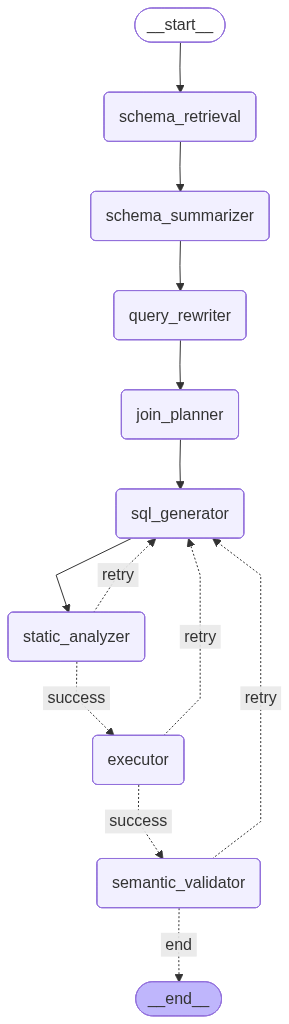

In [41]:
from IPython.display import Image, display
png = graph.get_graph().draw_mermaid_png()
display(Image(png))


In [42]:
DEFAULT_THREAD = "demo-chat-1"

async def chat(query: str, thread_id: str = DEFAULT_THREAD):
    # ONLY pass new message + user_query
    incoming = {
        "messages": [{"role": "user", "content": query}],
        "user_query": query,
    }

    # thread_id tells LangGraph to load previous memory
    config = {"configurable": {"thread_id": thread_id}}

    # Capture event-by-event execution trace
    print("\n--- EXECUTION TRACE ---")
    async for event in graph.astream(incoming, config=config, stream_mode="updates"):
        print(event)

    print("\n--- FINAL STATE ---")
    # Let LangGraph merge incoming with checkpointed state
    state = await graph.ainvoke(incoming, config=config)
    print("Final SQL:", state.get("sql_query"))
    print("Result:", state.get("sql_result"))
    print("Error:", state.get("error"))
    
    return {
        "sql": state.get("sql_query"),
        "result": state.get("sql_result"),
        "error": state.get("error"),
        "history": state.get("conversation_history"),
        "last_sql": state.get("last_sql"),
        "last_result": state.get("last_result"),
    }


In [43]:
# Example interactive calls
resp = await chat("What is total order_amount for 2024?")
print(resp)


# resp2 = await chat("Break it down by month")
# print(resp2)


--- EXECUTION TRACE ---
{'schema_retrieval': {'messages': [{'role': 'system', 'content': "Schema retrieval OK: ['blinkit_orders', 'blinkit_delivery_performance', 'blinkit_marketing_performance', 'blinkit_customers', 'blinkit_customer_feedback', 'blinkit_products']"}], 'schema_json': '{"blinkit_orders": {"columns": ["order_id", "customer_id", "order_date", "promised_delivery_time", "actual_delivery_time", "delivery_status", "order_total", "payment_method", "delivery_partner_id", "store_id"], "source": "./data/blinkit_orders.csv", "row_count": 5000, "columns_meta": {"order_id": {"semantic_type": "numeric", "distinct_values": [1961864118, 1549769649, 9185164487, 9644738826, 5427684290, 3265154092, 4898355547, 6568151549, 6006693867, 374186990, 4455336265, 3539286337, 9171116867, 5504941865, 5868326481, 2137046916, 8195544338, 2889700050, 65827885, 4656471694], "sample_values": ["1961864118", "1549769649", "9185164487", "9644738826", "5427684290"], "n_unique": 5000, "n_null": 0, "min": 60

In [45]:
resp2 = await chat("Which customer segments experience the highest delivery delays?")
print(resp2)


--- EXECUTION TRACE ---
{'schema_retrieval': {'messages': [{'role': 'system', 'content': "Schema retrieval OK: ['blinkit_customer_feedback', 'blinkit_orders', 'blinkit_delivery_performance', 'blinkit_customers', 'blinkit_order_items', 'blinkit_products', 'blinkit_marketing_performance', 'blinkit_inventoryNew']"}], 'schema_json': '{"blinkit_customer_feedback": {"columns": ["feedback_id", "order_id", "customer_id", "rating", "feedback_text", "feedback_category", "sentiment", "feedback_date"], "source": "./data/blinkit_customer_feedback.csv", "row_count": 5000, "columns_meta": {"feedback_id": {"semantic_type": "numeric", "distinct_values": [2234710, 5450964, 482108, 4823104, 3537464, 4089724, 230696, 2259308, 7380970, 2257242, 1837573, 258023, 3081099, 3158837, 9465932, 8111644, 121425, 8267419, 7168244, 2482108], "sample_values": ["2234710", "5450964", "482108", "4823104", "3537464"], "n_unique": 5000, "n_null": 0, "min": 947.0, "max": 9999293.0}, "order_id": {"semantic_type": "numeric"